## Radius measurement at different z-sections

Until now, the colony images were taken through ~4mm agar. The GFP signal got distorted, and very noisy images were formed. The formed noise made it very hard to automate height measurements. Even with a naked eye, it was close to impossible to find the top of the colony. In this example, Glu 04/17/2021 and Gly 04/17/2021, there is nothing in between the lens and the colony, so the GFP signal is very clear. This opens up the possibility of automated radius and height measurements!

In [1]:
%matplotlib notebook

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr
import pandas as pd
import datetime

from matplotlib import pyplot as plt

from bs4 import BeautifulSoup

from find_circle import make_circle

In [2]:
# Go through each merged file and collect the resized image in a numpy array
def get_image_sequence(video_folder, exp_name, acq_name, t_str, zstr_ar, img_dims):
    # Initialize the img numpy array
    img_seq = np.zeros((img_dims[0], img_dims[1], len(zstr_ar)), np.uint8)
    # Go over each z-stack image
    video_path = os.path.join(video_folder, f"{exp_name}_{acq_name}", f"{exp_name}_{acq_name}.avi")

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)
    for zix in range(len(zstr_ar)):
        z_str = zstr_ar[zix]
        # Collect the path of the merged files
        try:
            success, frame = vidcap.read()
            
            # Convert to grayscale
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Add to image sequence array
            img_seq[:,:,zix] = frame_gray

        except Exception as e:
            print(success)
            print(f"Error! Cannot read video from path {video_path}")
        
    return img_seq

In [66]:
exp_name = "EQ59_Gly_04242021"
exp_folder = os.path.join("D:\\", "Tolga", f"{exp_name}")
inner = True
tstr = "t0"
dim = (512,512)
ksz_um = 10 # Kernel size for filters in um

plate_csv_path = os.path.join(exp_folder, f"{exp_name}_Plates.csv")
timepoint_csv_path = os.path.join(exp_folder, f"{exp_name}_TimePoints.csv")

plate_df = pd.read_csv(plate_csv_path)
timepoint_df = pd.read_csv(timepoint_csv_path)
df = plate_df.merge(timepoint_df, on="plate_id", how="inner")

tar = [] # Timepoint in hours
tpid_rh_lst = []
height = [] # Max height: surface to top at the center
radius = [] # Max radius: center to edge at the surface

rarz = [] # for each acquisition, collect radius at each z-section
zarz = [] # each acquisition has its own z-sections. save all z values

cross_section_df = pd.DataFrame()
# Run through each acquisition
for (index,row) in df.iterrows():
#     if index == 1:
#         break
    # something is wrong with tp_id = 6 for  Glucose
    plt_id = row["plate_id"]
    tp_id = row["timepoint_id"]
    
    print(f"plate_id: {plt_id} - tp_id: {tp_id}")

#     if tp_id == 6:
#         continue
    
    acq_name = f"TileScan_Plt{plt_id}_Tp{tp_id}"
    metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner=inner)

    hours = (metadata["start_time"]- pd.Timestamp(row["time_prepared"])).total_seconds()/3600
    tar.append(hours)
    
    # Calculate kernel size in pixels for fixed length
    xvoxel = metadata["dimensions"]["X"]["Voxel"]
    yvoxel = metadata["dimensions"]["Y"]["Voxel"]
    xnum = metadata["dimensions"]["X"]["NumberOfElements"]
    ynum = metadata["dimensions"]["Y"]["NumberOfElements"]
    w = metadata["tiles"]["xix_unique_ar"].size*xnum
    h = metadata["tiles"]["yix_unique_ar"].size*ynum

    ksz_um = 10 # Kernel size for filters in um

    ksz_px = ksz_um/xvoxel
    # Make kernel size an odd integer
    ksz_px = int(ksz_px/2)*2 + 1
    print(f"width: {w} - height: {h}")
    print(f"kernel um: {ksz_um} - kernel px: {ksz_px}")
    
    # Go through each z and collect radius 
    zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
    zvoxel = -metadata["dimensions"]["Z"]["Voxel"]
    zar_um = []
    rar_um = []
    tp_id_lst = []
    
    # First, collect image sequence
    # Find the number of digits
    znum_digit = len(str(zsz-1))
    # zstr for file path
    zstr_holder = f"z%0{znum_digit}d"

    # calculate z_strar for each z_str value
    z_strar = np.zeros(zsz, dtype="<U6")
    for zix in range(zsz):
        z_strar[zix] = zstr_holder % zix


    # Read an image
    video_folder = os.path.join(exp_folder, "Videos_Full_Unmarked")

    print("\nCollecting image sequence")
    img_seq = get_image_sequence(video_folder, exp_name, acq_name, tstr, z_strar, dim)
    
    print("Calculating radius for each z-section: ")
    for zix in range(zsz):
#         print(f"{zix}/{zsz}", end="\r", flush=True)
        roi_image = img_seq[:, :, zix]
        blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
    #     blurred_image = roi_image
        _, thresh_image = cv2.threshold(blurred_image, 80, 255, cv2.THRESH_BINARY)

        zar_um.append(zix*zvoxel)
        tp_id_lst.append(tp_id)
        
#         # Parse the positive points into 
#         (yix,xix) = np.where(thresh_image>0)
        contours, hierarchy = cv2.findContours(np.uint8(thresh_image>0), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 0:
            points = np.vstack(contours).squeeze()
#             points = []
#             for ix in range(len(xix)):
#                 points.append((xix[ix], yix[ix]))
            (x,y,rad) = make_circle(points)
            rar_um.append(rad*xvoxel*w/dim[0])

        else:
            rar_um.append(0)
            
    # Calculate height
    r = np.array(rar_um)
    z = np.array(zar_um)
    idx, = np.where(r > 0)
    surf = z[np.argmax(r)]
    top = z[idx[-1]]
    h = top-surf
    
    # Calculate max radius
    
    tpid_rh_lst.append(tp_id)
    radius.append(max(r))
    height.append(h)
    rarz.append(rar_um)
    zarz.append(zar_um)
    
    data = {"timepoint_id": tp_id_lst, "z(um)": z, "z-surf(um)": z-surf, "r(um)": r}
    cross_section_df = cross_section_df.append(pd.DataFrame(data), ignore_index=True)

plate_id: 1 - tp_id: 5
width: 3072 - height: 3072
kernel um: 10 - kernel px: 19

Calculating radius for each z-section: 
plate_id: 1 - tp_id: 10
width: 4096 - height: 4096
kernel um: 10 - kernel px: 19

Calculating radius for each z-section: 
plate_id: 1 - tp_id: 15
width: 4096 - height: 4096
kernel um: 10 - kernel px: 13

Calculating radius for each z-section: 
plate_id: 1 - tp_id: 20
width: 5120 - height: 5120
kernel um: 10 - kernel px: 11

Calculating radius for each z-section: 
plate_id: 1 - tp_id: 25
width: 4096 - height: 4096
kernel um: 10 - kernel px: 11

Calculating radius for each z-section: 
plate_id: 2 - tp_id: 4
width: 3072 - height: 3072
kernel um: 10 - kernel px: 19

Calculating radius for each z-section: 
plate_id: 2 - tp_id: 9
width: 4096 - height: 4096
kernel um: 10 - kernel px: 17

Calculating radius for each z-section: 
plate_id: 2 - tp_id: 14
width: 4096 - height: 4096
kernel um: 10 - kernel px: 13

Calculating radius for each z-section: 
plate_id: 2 - tp_id: 19
wid

In [67]:
cross_section_df.to_csv(os.path.join(exp_folder, f"{exp_name}_CrossSection.csv"), index=False)

<IPython.core.display.Javascript object>


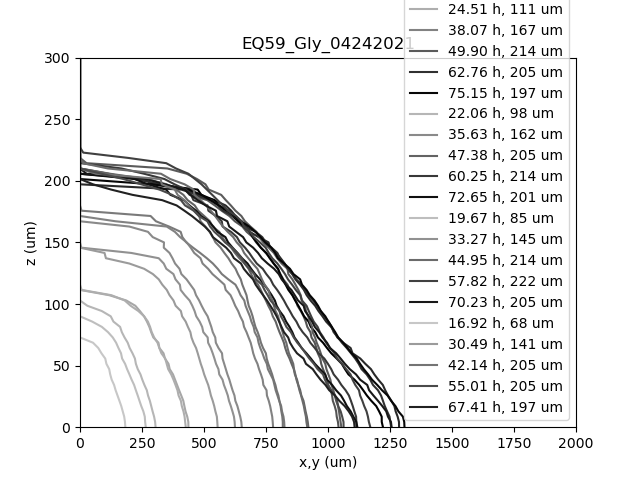

Text(0.5, 1.0, 'EQ59_Gly_04242021')

In [68]:
# Cross-sections
fig,ax = plt.subplots()
for rix in range(len(rarz)):
    # Rearrange the z values
    r = np.array(rarz[rix])
    z = np.array(zarz[rix])
    idx, = np.where(r > 0)
    surf = z[np.argmax(r)]
    top = z[idx[-1]]
    h = top-surf
    c = 1-tar[rix]/max(tar)
    ax.plot(r, z-surf, color=(c,c,c), label="%.2f h, %d um" % (tar[rix], h))
    
ax.legend()
ax.set_xlim(0, 2000)
ax.set_ylim(0,300)
ax.set_xlabel("x,y (um)")
ax.set_ylabel("z (um)")
ax.set_title(exp_name)

<IPython.core.display.Javascript object>


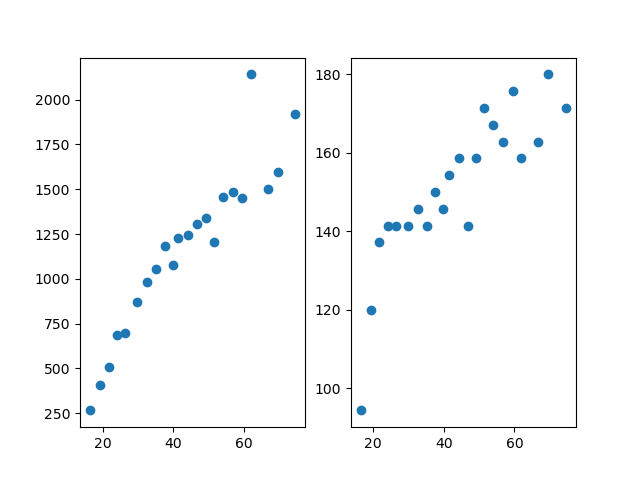

In [61]:
# height and radius
fig, axs = plt.subplots(1,2)
axs[0].plot(tar, radius, 'o')
axs[1].plot(tar, height, 'o')


In [69]:
radius_height_data = {"timepoint_df": tpid_rh_lst, "radius(um)": radius, "height(um)": height}
radius_height_df = pd.DataFrame(radius_height_data)
radius_height_df.to_csv(os.path.join(exp_folder, f"{exp_name}_RadiusHeight.csv"), index=False)

In [70]:
radius_height_df

,timepoint_df,radius(um),height(um)
0,5,437.175565,107.150
1,10,824.511846,175.726
2,15,1042.584618,205.728
3,20,1286.600990,192.870
4,25,1221.651073,201.442
5,4,426.536783,111.436
6,9,778.598393,167.154
7,14,1053.826641,214.300
8,19,1254.946944,205.728
9,24,1308.432138,197.156


### Let's try with a single image where colony is clear.
The purpose at this point is to look at some parameters, where the radius can be measured for an arbitrary z-section

In [ ]:
exp_name = "EQ59_Glu_04172021"
plt_ids = [1,1,1,2,2,3,3,3,4,4,5,5]
tp_ids = [2,8,12,3,7,1,6,11,5,10,4,9]

# exp_name = "EQ59_Gly_04172021"
# plt_ids = [3,2,1,4,3,2,1,5,4,3,2,1]
# tp_ids = [1,2,3,4,5,6,7,8,9,10,11,12]
exp_folder = os.path.join("E:", "Tolga", f"{exp_name}")
acq_name_lst = []
for ix in range(len(plt_ids)):
    acq_name = f"TileScan_Plt{plt_ids[ix]}_Tp{tp_ids[ix]}"
    acq_name_lst.append(acq_name)
    
pix = 3
plt_id = plt_ids[pix]
tp_id = tp_ids[pix]
print(f"plt_id = {plt_id}, tp_id = {tp_id}")
acq_name = f"TileScan_Plt{plt_id}_Tp{tp_id}"
inner = True

In [ ]:
metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner=inner)
metadata

In [ ]:
xvoxel = metadata["dimensions"]["X"]["Voxel"]
yvoxel = metadata["dimensions"]["Y"]["Voxel"]
xnum = metadata["dimensions"]["X"]["NumberOfElements"]
ynum = metadata["dimensions"]["Y"]["NumberOfElements"]
width = metadata["tiles"]["xix_unique_ar"].size*xnum
height = metadata["tiles"]["yix_unique_ar"].size*ynum

ksz_um = 10 # Kernel size for filters in um

ksz_px = ksz_um/xvoxel
# Make kernel size an odd integer
ksz_px = int(ksz_px/2)*2 + 1
print(f"width: {width} - height: {height}")
print(f"kernel um: {ksz_um} - kernel px: {ksz_px}")

In [ ]:
tstr = "t0"
dim = (512,512)
zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
# Find the number of digits
znum_digit = len(str(zsz-1))
# zstr for file path
zstr_holder = f"z%0{znum_digit}d"

# calculate z_strar for each z_str value
z_strar = np.zeros(zsz, dtype="<U6")
for zix in range(zsz):
    z_strar[zix] = zstr_holder % zix


# Read an image
merged_folder = os.path.join(exp_folder, "Merged")

img_seq = get_image_sequence(merged_folder, exp_name, acq_name, tstr, z_strar, dim, ksz_px)

In [ ]:
img_seq_circle = np.zeros((dim[0], dim[1], zsz), dtype=np.uint8) # numpy 3d array image sequence to track max intensity images
img_seq_circle_thresh = np.zeros_like(img_seq_circle) # numpy 3d array image sequence to track max intensity images
centers_px = []
rar_px = []
rar_um = []
for zix in range(zsz):
    print(f"Calculating {zix}/{zsz}", end="\r", flush=True)
    roi_image = img_seq[:, :, zix]
    blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
#     blurred_image = roi_image
    _, thresh_image = cv2.threshold(blurred_image, 80, 255, cv2.THRESH_BINARY)

    # Parse the positive points into 
    (yix,xix) = np.where(thresh_image>0)
    if yix.size > 0:
        points = []
        for ix in range(len(xix)):
            points.append((xix[ix], yix[ix]))
        (x,y,rad) = make_circle(points)
        centers_px.append((x,y))
        rar_px.append(rad)
        rar_um.append(rad*xvoxel*width/dim[0])

    else:
        centers_px.append((0,0))
        rar_px.append(0)
        rar_um.append(0)
    
#     cv2.circle(blurred_image, (centerx, centery), radius, (255,255,255), 1)
    img_seq_circle[:,:,zix] = blurred_image
    img_seq_circle_thresh[:,:,zix] = thresh_image

In [ ]:
width/dim[0]

In [ ]:
znum = metadata["dimensions"]["Z"]["NumberOfElements"]
zvoxel = metadata["dimensions"]["Z"]["Voxel"]
zar = np.linspace(znum*zvoxel, 0, znum)
fig, ax = plt.subplots()
ax.plot(rar_um, zar, '-')

In [ ]:
img = img_seq_circle_thresh[:,:,74]
(yix,xix) = np.where(img>0)
points = []
for ix in range(len(xix)):
    points.append((xix[ix], yix[ix]))
    
(x,y,rad) = make_circle(points)

img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
cv2.circle(img_color, (round(x), round(y)), round(rad), (255,255, 0), 4)
fig,ax = plt.subplots()
ax.imshow(img_color)

## Automated radius calculation seems to work here. Test for all timepoints
- Calculate timepoints from the saved csv
- Calculate radius at each z-section for each timepoint
- plot rad(z) for different timepoints
- ?? interactive plot of rad(z) using tracker
- plot max(rad) vs time to see the radial growth
- plot max(height) vs time to see the growth in height

In [ ]:
df = plate_df.merge(timepoint_df, on="plate_id", how="inner")
# df.apply(calculate_timepoint, args=(exp_name, exp_folder, inner))
df

In [ ]:
for (ix,row) in df.iterrows():
    print(row)

In [ ]:
fig,ax = plt.subplots()
for rix in range(len(rarz)):
    # Rearrange the z values
    r = np.array(rarz[rix])
    z = np.array(zarz[rix])
    idx, = np.where(r > 0)
    surf = z[idx[0]]
    top = z[idx[-1]]
    height = top-surf

    ax.plot(r, z-surf, label="%.2f h, %d um" % (tar[rix], height))
    
ax.legend()
ax.set_xlim(0, 2000)
ax.set_ylim(-50,400)

In [ ]:
# Timepoints
plate_csv_path = os.path.join(exp_folder, f"{exp_name}_Plates.csv")
timepoint_csv_path = os.path.join(exp_folder, f"{exp_name}_TimePoints.csv")

plate_df = pd.read_csv(plate_csv_path)
timepoint_df = pd.read_csv(timepoint_csv_path)

# (metadata["start_time"]- pd.Timestamp(plate_df["time_prepared"][0])).seconds/3600

In [ ]:
# Radius at each z-section (save to a 2d numpy array)

In [ ]:
# Plots rad(z) for different timepoints

In [ ]:
# Calculate rad vs time and height vs time

In [ ]:
# Plot rad vs time and height vs time

In [ ]:
height